In [349]:
from __future__ import division, print_function, absolute_import
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline
matplotlib.rcParams.update({'font.size':16})

from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.io import votable
from astropy.utils import data
data.conf.remote_timeout = 60 # default is 3 seconds

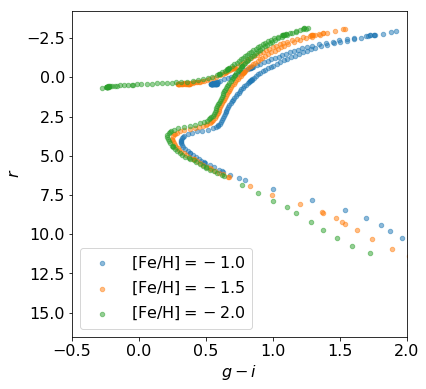

In [350]:
# isochrone data
isoc1 = Table.read('t=12Gyr_Fe=-1.0.dat',format='ascii')
isoc1 = Table(isoc1,names=('metallicity','logage','M_ini','M_act','logL/Lo','logTe','logG','mbol',
                           'g','r','i','z','y','w','int_IMF','stage'))

isoc15 = Table.read('t=12Gyr_Fe=-1.5.dat',format='ascii')
isoc15 = Table(isoc15,names=('metallicity','logage','M_ini','M_act','logL/Lo','logTe','logG','mbol',
                             'g','r','i','z','y','w','int_IMF','stage'))

isoc2 = Table.read('t=12Gyr_Fe=-2.0.dat',format='ascii')
isoc2 = Table(isoc2,names=('metallicity','logage','M_ini','M_act','logL/Lo','logTe','logG','mbol',
                           'g','r','i','z','y','w','int_IMF','stage'))

# isochrone plot
f = pl.figure(figsize=(6,6))
pl.scatter(isoc1['g']-isoc1['i'],isoc1['r'],
           alpha=0.5,s=20,label=r'$[\rm{Fe/H}] = -1.0$')
pl.scatter(isoc15['g']-isoc15['i'],isoc15['r'],
           alpha=0.5,s=20,label=r'$[\rm{Fe/H}] = -1.5$')
pl.scatter(isoc2['g']-isoc2['i'],isoc2['r'],
           alpha=0.5,s=20,label=r'$[\rm{Fe/H}] = -2.0$')
pl.xlim(-0.5,2)
pl.gca().invert_yaxis()
pl.xlabel(r'$g-i$')
pl.ylabel(r'$r$')
pl.legend(loc='lower left')

In [361]:
# VOTable
url_templ = 'http://gsss.stsci.edu/webservices/vo/CatalogSearch.aspx?CAT=PS1V3OBJECTS&RA={ra}&DEC={dec}&SR={rad}'
search_radius = 5/60. # degrees
gal = SkyCoord.from_name('Draco dSph')
ra = gal.ra.deg
dec = gal.dec.deg
url = url_templ.format(ra=ra,dec=dec,rad=search_radius)
tab = votable.parse_single_table(url).to_table()

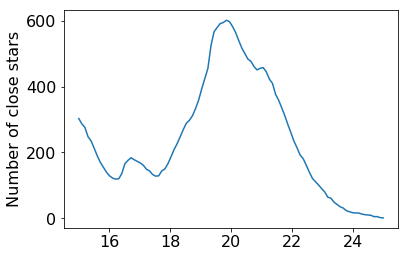

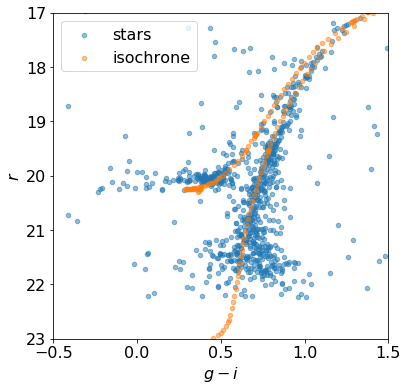

In [367]:
# Find best-fit isochrone
star_tab = tab[tab['iMeanPSFMag']-tab['iMeanKronMag'] < 0.05]
star_tab = star_tab[(star_tab['gMeanPSFMag'] != -999)*(star_tab['iMeanPSFMag'] != -999)]

distance = np.linspace(15,25,100)
numclosestars = np.zeros(distance.size)

for j in range(distance.size):
    for i in range(star_tab['rMeanPSFMag'].size):
        point = np.array([star_tab['gMeanPSFMag'][i]-star_tab['iMeanPSFMag'][i],
                          star_tab['rMeanPSFMag'][i]]).reshape(-1,1)
        iso = np.array([isoc15['g']-isoc15['i'],isoc15['r']+distance[j]])
        if np.any( (np.abs(point[1]-iso[1]) < 0.3)*(np.abs(point[0]-iso[0]) < 0.1) ):
            numclosestars[j] += 1

pl.plot(distance,numclosestars)
pl.ylabel('Number of close stars')
bestdist = distance[numclosestars==numclosestars.max()]

# Galaxy CMD with best-fit isochrone
f = pl.figure(figsize=(6,6))
pl.scatter(star_tab['gMeanPSFMag']-star_tab['iMeanPSFMag'],star_tab['rMeanPSFMag'],
           s=20,alpha=0.5,label='stars')
pl.xlim(-0.5,1.5)
pl.ylim(17,23)
pl.xlabel(r'$g-i$')
pl.ylabel(r'$r$')
pl.gca().invert_yaxis()

pl.scatter(isoc15['g']-isoc15['i'],isoc15['r']+bestdist[0],
           s=20,alpha=0.5,label=r'isochrone')
pl.legend()